# Some algorithms based on random processes

Poisson point process and Chentsov simulation in 1D, 2D and 3D.

## Import what is required

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pyvista as pv

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.4


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Links between Bernoulli, binomial, Poisson and normal (gaussian) random variables
Consider 
- $X\sim \mathcal{B}(p)$: Bernoulli random variable (discrete) taking the value $0$ with probability $1-p$ and $1$ with probability $p$,
- $Y\sim \mathcal{B}(n, p)$: binomial random variable (discrete) defined as the sum of $n$ independent Bernoulli random variables, i.e. $$\mathbb{P}(Y=k)=\binom{n}{k}p^k (1-p)^{n-k},\ \text{for}\ k=0, \ldots, n,$$
- $V\sim \mathcal{Pois}(\mu)$: Poisson random variable (discrete), taking the values in $\mathbb{N}$ with 
$$\mathbb{P}(V=k)=\frac{\mu^k}{k!}e^{-\mu},\ \text{for}\ k\geqslant 0,$$
- $Z\sim \mathcal{N}(\mu, \sigma^2)$ a normal random variable (continuous), whose the density function is 
$$f_Z(z)=\frac{1}{\sqrt{2\pi}\cdot\sigma}\exp\left(-\frac{1}{2}\cdot\frac{(z-\mu)^2}{\sigma^2}\right)$$

### Poisson random variable as the limit of binomial random variables
With $\mu = n\cdot p$ (fixed), $Y$ tends towards $V$ when $n\to\infty$ (and then $p\to 0$). Thus, a binomial random variable $\mathcal{B}(n, p)$ with $n$ large and $p$ small can be approximated by a Poisson random variable $\mathcal{Pois}(np)$.

Note that by the central limit theroem (CLT), for $n$ large, a binomial random variable $\mathcal{B}(n, p)$ can be approximated by a normal law $\mathcal{N}(np, np(1-p))$.

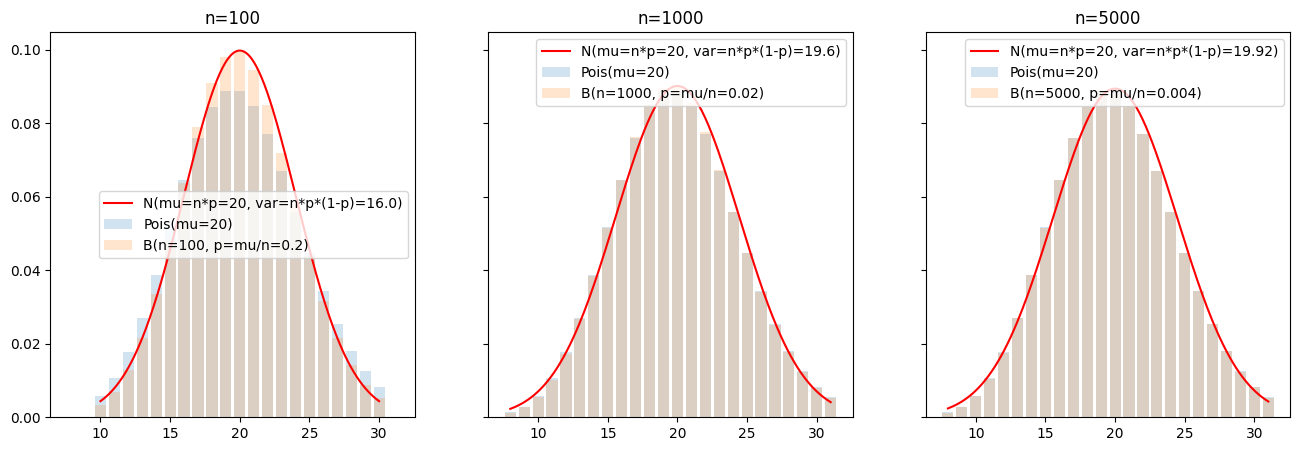

In [4]:
# Parameter mu of the Poisson law (its mean)
mu = 20. 

# Parameter n, p of the binomial law s.t. np = mu, with different values for n

plt.subplots(1, 3, figsize=(16,5), sharex=True, sharey=True)
for i, n in enumerate([100, 1000, 5000]):
    p = mu/n  

    var = n*p*(1-p)   # variance of the binomial law
    sd = np.sqrt(var) # standard deviation of the binomial law

    x = np.arange(max(int(mu - 2.5*sd), 0), min(int(mu + 2.5*sd + 1), n+1))

    px = stats.poisson.pmf(x, mu) # probability mass function of the Poisson law
    bx = stats.binom.pmf(x, n, p) # probability mass function of the binomial law

    t = np.linspace(x.min(), x.max(), 200)
    y = stats.norm.pdf(t, loc=mu, scale=sd) # pdf of the normal law N(mu, var)
    
    plt.subplot(1, 3, i+1)
    plt.bar(x, px, alpha=.2, label='Pois(mu={:.4g})'.format(mu))
    plt.bar(x, bx, alpha=.2, label='B(n={}, p=mu/n={:.4g})'.format(n, p))
    plt.plot(t, y, color='red', label='N(mu=n*p={:.4g}, var=n*p*(1-p)={})'.format(mu, var))
    plt.legend()
    plt.title('n={}'.format(n))
plt.show()

## Poisson point process
Consider a domain $\Omega$ and a parameter $\mu$. 

A Poisson point process consists in drawing a number $N$ following a Poisson law $\mathcal{Pois}(\mu\cdot\text{vol}(\Omega))$ and then drawing uniformly $N$ random points in $\Omega$.

Then a Poisson point process of a parameter $\mu$ gives, in mean, $\mu$ points per unitary volume, randomly (uniformly) located, $\mu$ is the *intensity*.

The function `geone.randProcess.poissonPointProcess` allows to generates points (in any dimension) according to a Poisson point process. See the examples below.

### Homogeneous Poisson point process
The parameter $\mu$ is constant on $\Omega$.

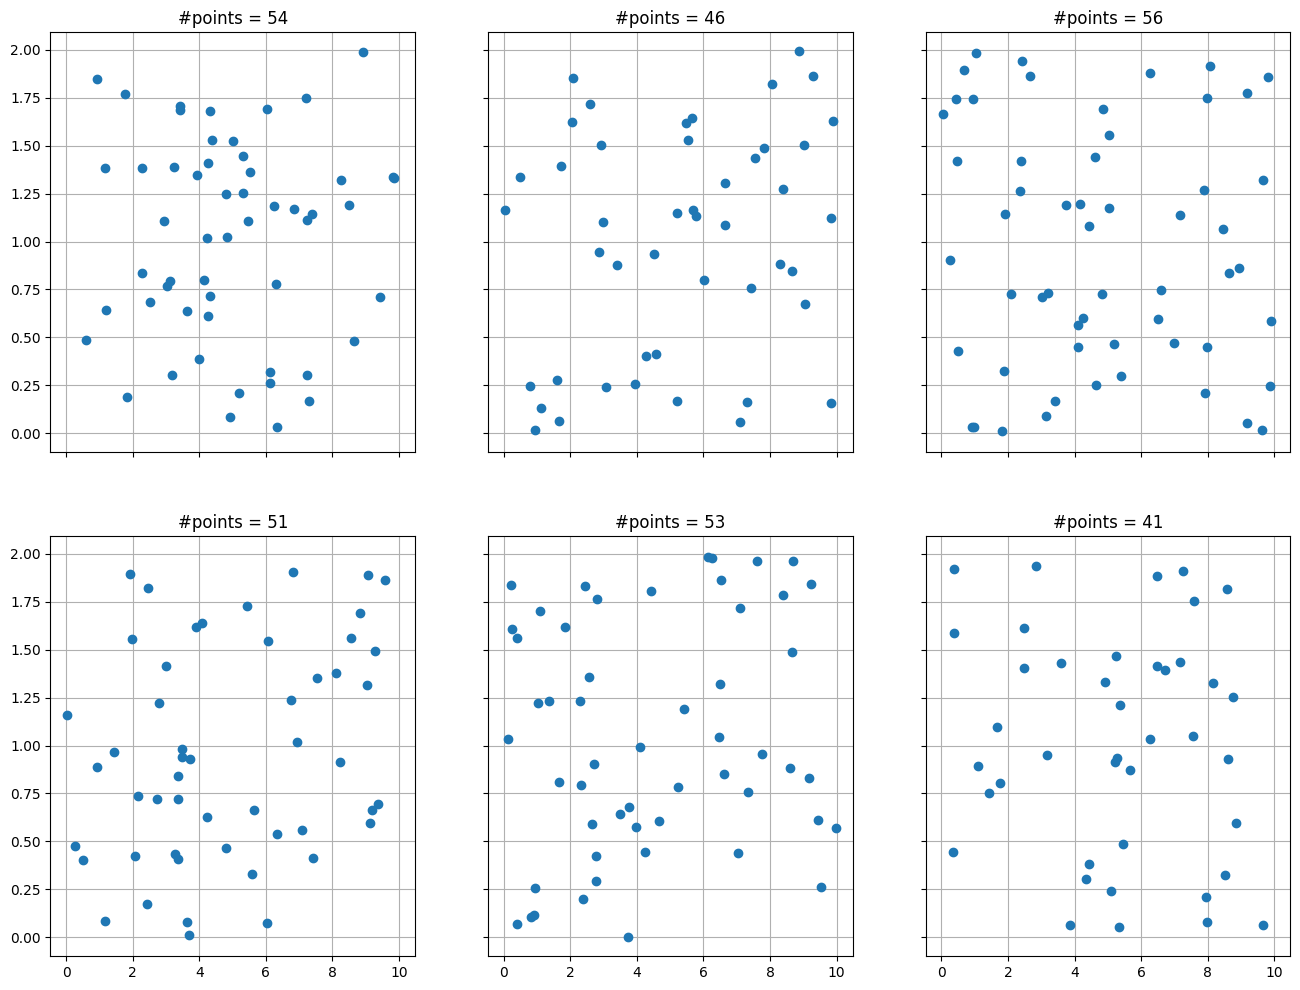

Mean number of points in the domain: 50
Volume of the domain: 20
Poisson parameter mu: 2.5


In [5]:
# Domain omega
xmin = (0, 0)
xmax = (10, 2)

# Mean number of point in omega 
n_mean = 50

# Set parameters mu of the Poisson point process
vol = np.prod(np.asarray(xmax) - np.asarray(xmin)) # volume (area) of omega
mu = n_mean / vol # mean number of points per unitary volume

# Realizations of Poisson point process 
nreal = 6
np.random.seed(123) # set seed for reproducibility
pts = [gn.randProcess.poissonPointProcess(mu, xmin, xmax) for i in range(nreal)]

# Plot realizations
plt.subplots(2, 3, figsize=(16,12), sharex=True, sharey=True)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(pts[i][:,0], pts[i][:,1], marker='o', ls='')
    plt.grid()
    plt.title(f'#points = {pts[i].shape[0]}')
    
plt.show()

print(f'Mean number of points in the domain: {n_mean}')
print(f'Volume of the domain: {vol}')
print(f'Poisson parameter mu: {mu}')

### Non-homogeneous Poisson point process
The parameter $\mu$ is varying on $\Omega$.

### Parameter $\mu$ defined as a function (on $\Omega$)

In [6]:
# Define parameter mu as a function
def mu_f(x):
    """
    Function returning the density of point (mean number of point per unitary volume) as function of 
    the location (x0, x1): mu_f((x0, x1)) = 2*x0**2.
    Parameter x:
        array of shape (2,) (one location in 2D)
        or array of shape (n, 2) (n location(s) in 2D)
    """
    return 0.2*np.atleast_2d(x)[:,0]**2

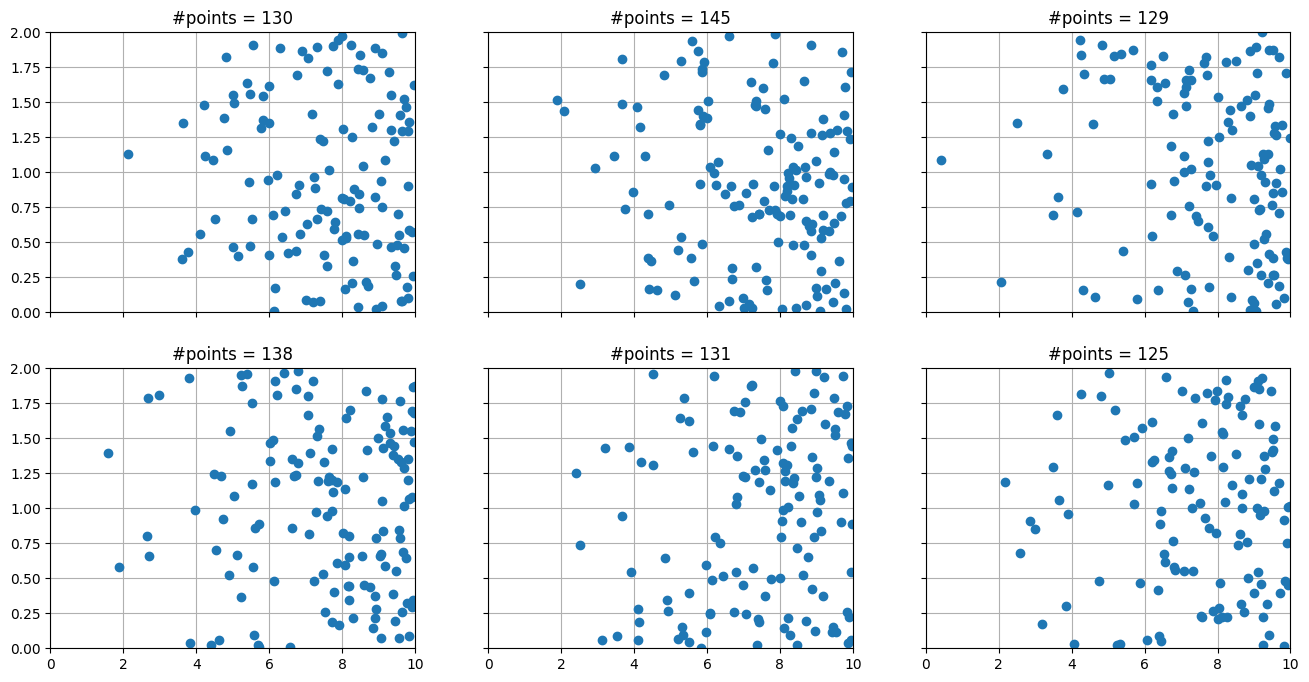

In [7]:
# Domain omega
xmin = (0, 0)
xmax = (10, 2)

# Resolution: number of intervals for subdividing the domain in each direction 
#   - coarse resolution can be set along x (resp. y) if mu does not depend on x (resp. y)
#   - in our example, mu (function mu_f) is constant along y axis
ninterval = (100,1)

# Realizations of Poisson point process 
nreal = 6
np.random.seed(123) # set seed for reproducibility
pts = [gn.randProcess.poissonPointProcess(mu_f, xmin, xmax, ninterval=ninterval) for i in range(nreal)]

# Plot realizations
plt.subplots(2, 3, figsize=(16,8), sharex=True, sharey=True)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(pts[i][:,0], pts[i][:,1], marker='o', ls='')
    plt.xlim((xmin[0], xmax[0]))
    plt.ylim((xmin[1], xmax[1]))
    plt.grid()
    plt.title('#points = {}'.format(pts[i].shape[0]))
    
plt.show()

In [8]:
def mu_f_2var(x, y):
    return mu_f(np.array([x,y]))
                
n_mean = integrate.nquad(mu_f_2var, [[xmin[0], xmax[0]], [xmin[1], xmax[1]]])[0]
print(f'Mean number of points in the domain: {n_mean}')
# Note: the integral of our function (x,y)-> 0.2*x^2 on the domain [0,10] x [0, 2] is equal to 400/3
# (the value of n_mean)

Mean number of points in the domain: 133.33333333333331


#### Plotting the function $\mu$ in the background

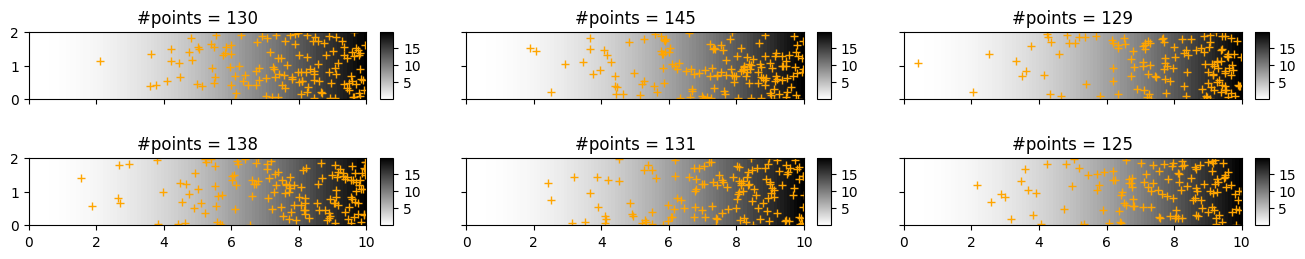

In [9]:
# Define image (Img class from geone.img) with the desired resolution
spacing = (np.asarray(xmax) - np.asarray(xmin)) / np.asarray(ninterval)
im_mu = gn.img.Img(nx=ninterval[0], ny=ninterval[1], nz=1, 
                   sx=spacing[0]  , sy=spacing[1],   sz=1., 
                   ox=xmin[0],      oy=xmin[1],      oz=0.,
                   nv=1, val=np.nan) # empty image

# Define values of mu in the image: values of the function at each cell center
yy_cell, xx_cell = im_mu.yy(), im_mu.xx()
# or:
yy_cell, xx_cell = np.meshgrid(im_mu.y(), im_mu.x(), indexing='ij') # coordinates of cell centers

xy_cell = np.array((xx_cell.reshape(-1), yy_cell.reshape(-1))).T # array of shape(n, 2) of coordinates of cell centers
mu_cell = mu_f(xy_cell) # value of mu on omega 
#mu_cell = mu_f_2var(xx_cell, yy_cell) # alternative
im_mu.set_var(mu_cell)

# Plot realizations
plt.subplots(2, 3, figsize=(16,3), sharex=True, sharey=True)
for i in range(6):
    plt.subplot(2, 3, i+1)
    gn.imgplot.drawImage2D(im_mu, cmap=gn.customcolors.cmapW2B, colorbar_aspect=5)
    plt.plot(pts[i][:,0], pts[i][:,1], marker='+', ls='', color='orange')
    plt.title('#points = {}'.format(pts[i].shape[0]))
    
plt.show()

### Parameter $\mu$ defined as an array (on $\Omega$)

An array of values for the parameter $\mu$ can be passed to the function `geone.randProcess.poissonPointProcess`. 

In [10]:
# Equivalent to previous realizations...
np.random.seed(123) # set seed for reproducibility
pts_B = [gn.randProcess.poissonPointProcess(im_mu.val[0,0,:,:], xmin, xmax) for i in range(nreal)]
[np.all(pts[i] == pts_B[i]) for i in range(nreal)]  # nreal times "True"

[True, True, True, True, True, True]

### Parameter $\mu$ defined as an array (or image) (on $\Omega$) - another example

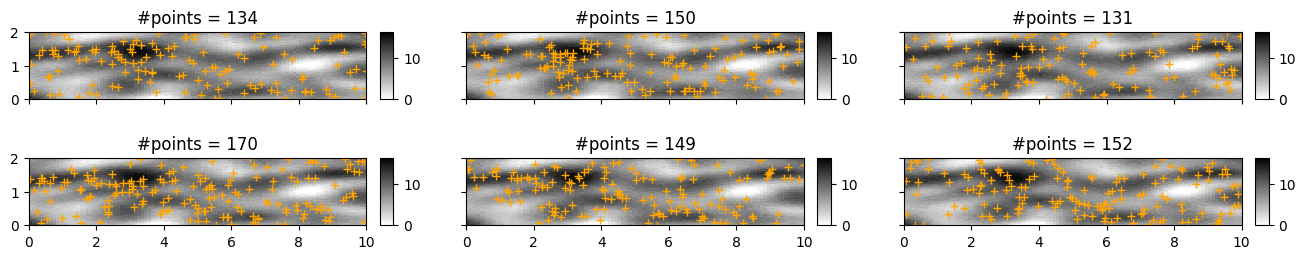

Mean number of points in the domain: 147.85458937609468


In [11]:
# Simulation domain (omega)
nx, ny = 100, 100  # number of cells in each direction
sx, sy = 0.1, 0.02 # cell size in each direction
ox, oy = 0.0, 0.0  # origin
# same domain as before...

# Set mu as a GRF simulation (truncated to positive value) (see other jupyter notebooks)
cov_model = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':10., 'r':[2., .2], 'nu':3.}), # elementary contribution
    ], name='model-2D example')
cov_model = gn.covModel.CovModel2D(elem=[
    ('gaussian', {'w':10., 'r':[2., .5]}), # elementary contribution
    ('nugget', {'w':.1})                   # elementary contribution
    ], name='model-2D example')

np.random.seed(111)
mu = gn.grf.grf2D(cov_model, (nx, ny), (sx, sy), mean=7., nreal=1, verbose=0)

# Truncate and Fill image (Img class)
im_mu = gn.img.Img(nx, ny, 1, sx, sy, 1.0, ox, oy, 0.0, nv=1, val=np.maximum(mu, 0.))
# Note: truncate values to have positive intensity


# Poisson point process realizations (with same mu image)
xmin = (ox, oy)
xmax = (ox+nx*sx, oy+ny*sy)

nreal = 6
np.random.seed(123) # set seed for reproducibility
pts = [gn.randProcess.poissonPointProcess(im_mu.val[0,0,:,:], xmin, xmax) for i in range(nreal)]

# Plot realizations
plt.subplots(2, 3, figsize=(16,3), sharex=True, sharey=True)
for i in range(6):
    plt.subplot(2, 3, i+1)
    gn.imgplot.drawImage2D(im_mu, cmap=gn.customcolors.cmapW2B, colorbar_aspect=5)
    plt.plot(pts[i][:,0], pts[i][:,1], marker='+', ls='', color='orange')
    plt.title('#points = {}'.format(pts[i].shape[0]))
    
plt.show()

print('Mean number of points in the domain: {}'.format(np.sum(im_mu.val[0,0,:,:])*im_mu.sx*im_mu.sy))

## Chentsov's simulation

The principle of Chentsov simulation in dimension $d$ is the following. First define:
- the "direction origin" $x_0 \in \mathbb{R}^d$,
- for a direction $v \in \mathbb{S}^{d-1}_+$, the half sphere in dimension $d-1$, and a real number $p$, consider the hyper-plane
$$H_{x_0, v, p} = \{x\in\mathbb{R}^d\ :\ (x-x_0)^t\cdot v = p\},$$
i.e. the points $x$ such that the projection of $x-x_0$ onto $v$ is equal to $p$.

A Chentsov simulation in $d$ dimension given a parameter $n_{mean}$ consists in drawing $n$ pairs 
$$(v_i, p_i)\in  \mathbb{S}^{d-1}_+ \times [p_{min}, p_{max}]$$
according to an homogeneous Poisson point process of intensity $\mu=n_{mean}/vol(\mathbb{S}^{d-1}_+)$, and then for any $x\in\mathbb{R}^d$, retrieving the number $Z(x)$ of hyper-planes (among $H_{x_0, v_i, p_i}, i=1,\ldots, n$) cut by the segment $[x_0, x]$. The field $Z$ is the resulting Chentsov simulation.

### Chentsov's simulation 1D - function `geone.randProcess.chentsov1D`
Note that for 1D, $\mathbb{S}^{d-1}_+$ is reduced to the point $\{1\}$. In addition to the definition of the simulation domain, the required parameters are 
- `direction_origin`: the point $x_0$; default: the center of the simulation domain,
- `p_min` and `p_max`: $p_{min}$ and $p_{max}$; default: $-/+$ half length of the simulation domain.

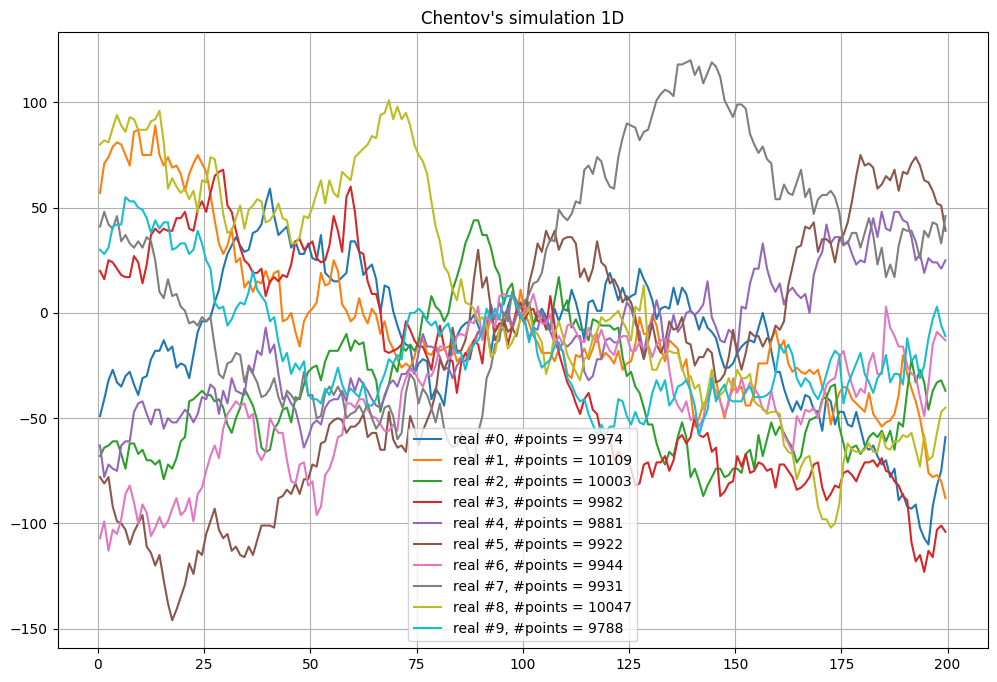

In [12]:
# Define simulation domain
nx = 200  # number of cells
sx = 1.0  # cell size
ox = 0.0  # origin

# Mean for total number of points (for Poisson process) 
n_mean = 10000

# Chentov's simulation
nreal = 10
np.random.seed(532) # set seed for reproducibility
sim, n_eff = gn.randProcess.chentsov1D(n_mean, nx, sx, ox, nreal=nreal) 
# -> sim: array of shape (nreal, nx), sim[i]: i-th real
# -> n_eff: array of shape (nreal,), number of points drawn for each real

# x coordinates of the cell center in 1D grid
x = ox + (np.arange(nx)+0.5)*sx

# Figure
plt.figure(figsize=(12,8))
for i in range(10):
    plt.plot(x, sim[i], label=f'real #{i}, #points = {n_eff[i]}')

plt.legend()
plt.grid()
plt.title("Chentov's simulation 1D")
plt.show()

### Chentsov's simulation 2D - function `geone.randProcess.chentsov2D`
Note that for 2D, $\mathbb{S}^{d-1}_+ = \mathbb{S}^{1}_+$ is the half circle. It is parametrized via
$$ \varphi \mapsto (\cos(\varphi), \sin(\varphi)).$$
In addition to the definition of the simulation domain, the required parameters are 
- `direction_origin`: the point $x_0$; default: the center of the simulation domain,
- `phi_min` and `phi_max`: $\varphi_{min}$ and $\varphi_{max}$ defining the interval of value for $\varphi$ (in the parametrization, this allows to consider only a part of $\mathbb{S}^{1}$); default: `\phi_min=0`, `phi_max=np.pi` (i.e. $\pi$),
- `p_min` and `p_max`: $p_{min}$ and $p_{max}$; default: $-/+$ half of the diagonal of the simulation domain.

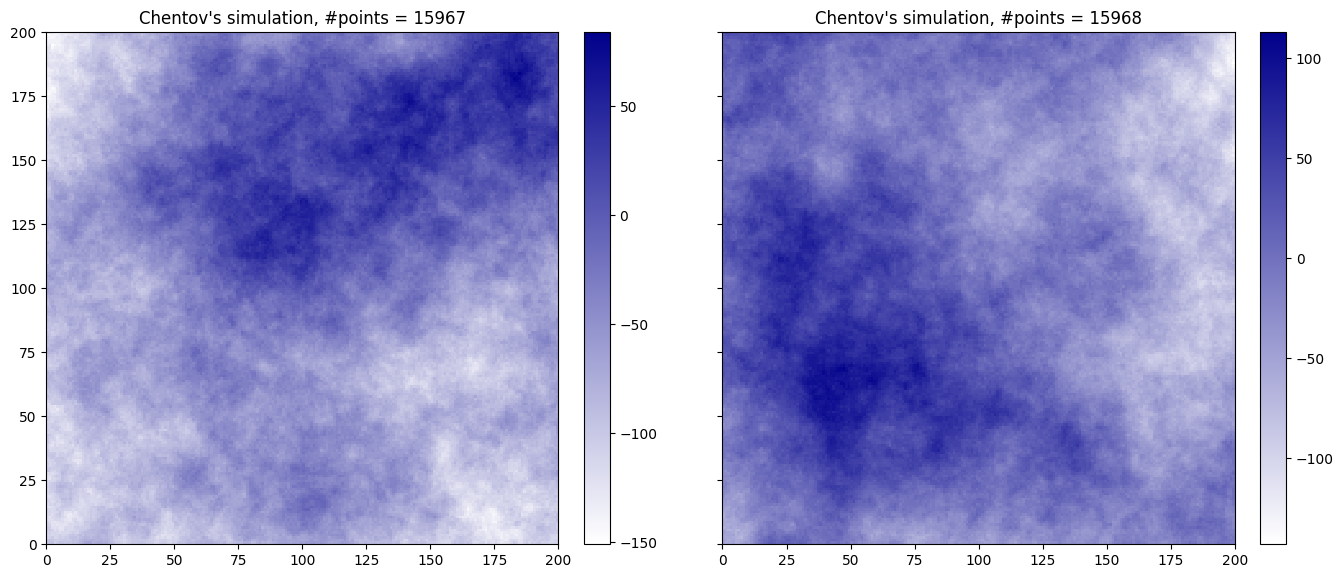

In [13]:
# Define simulation domain
nx, ny = 200, 200  # number of cells
sx, sy = 1.0, 1.0  # cell size
ox, oy = 0.0, 0.0  # origin

# Mean for total number of points (for Poisson process) 
n_mean = 16000

# Chentov's simulation
nreal = 2
np.random.seed(532) # set seed for reproducibility
sim, n_eff = gn.randProcess.chentsov2D(n_mean, (nx, ny), (sx, sy), (ox, oy), nreal=nreal)
# -> sim: array of shape (nreal, ny, nx), sim[i]: i-th real
# -> n_eff: array of shape (nreal,), number of points drawn for each real

# Fill image (Img class)
im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=nreal, val=sim)
del(sim)

# Figure
plt.subplots(1,2, figsize=(16,8), sharex=True, sharey=True)
cmap = gn.customcolors.custom_cmap(['white', 'darkblue'])
for i in range(2):
    plt.subplot(1,2,i+1)
    gn.imgplot.drawImage2D(im, iv=i, cmap=cmap) 
    plt.title(f"Chentov's simulation, #points = {n_eff[i]}")

plt.show()

### Chentsov's simulation 3D - function `geone.randProcess.chentsov3D`
Note that for 3D, $\mathbb{S}^{d-1}_+ = \mathbb{S}^{2}_+$ is the half sphere. It is parametrized via
$$ (\varphi, \vartheta) \mapsto (\cos(\varphi)\cos(\vartheta), \sin(\varphi)\cos(\vartheta), \sin(\vartheta)).$$
In addition to the definition of the simulation domain, the required parameters are 
- `direction_origin`: the point $x_0$; default: the center of the simulation domain,
- `phi_min` and `phi_max`: $\varphi_{min}$ and $\varphi_{max}$ defining the interval of value for $\varphi$ (in the parametrization); default: `\phi_min=0`, `phi_max=2*np.pi` (i.e. $2\pi$),
- `theta_min` and `theta_max`: $\vartheta_{min}$ and $\vartheta_{max}$ defining the interval of value for $\varphi$ (in the parametrization); default: `\phi_min=0`, `phi_max=np.pi/2` (i.e. $\pi/2$),
- `p_min` and `p_max`: $p_{min}$ and $p_{max}$; default: $-/+$ half of the diagonal of the simulation domain.
- `param ninterval_theta`: (int) number of sub-intervals in which the interval $[\vartheta_{min}, \vartheta_{max}]$ is subdivided for applying the Poisson process (it allows to account for the jacobian of the parametrization of $\mathbb{S}^{2}$, i.e. accounting for "elementary" volume (area) in $\mathbb{S}^{2}$); default: 100.

Note that the default value for `phi_min`, `phi_max`, `theta_min`, `theta_max` corresponds to the half sphere $\mathbb{S}^{2}_+$.

In [14]:
# Define simulation domain
nx, ny, nz = 31, 31, 31  # number of cells
sx, sy, sz = 1.0, 1.0, 1.0 # cell size
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Mean for total number of points (for Poisson process) 
n_mean = 50000

# Chentov's simulation
nreal = 1
np.random.seed(532) # set seed for reproducibility
sim, n_eff = gn.randProcess.chentsov3D(n_mean, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), nreal=nreal)
# -> sim: array of shape (nreal, nz, ny, nx), sim[i]: i-th real
# -> n_eff: array of shape (nreal,), number of points drawn for each real

# Fill image (Img class)
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=nreal, val=sim)
del(sim)

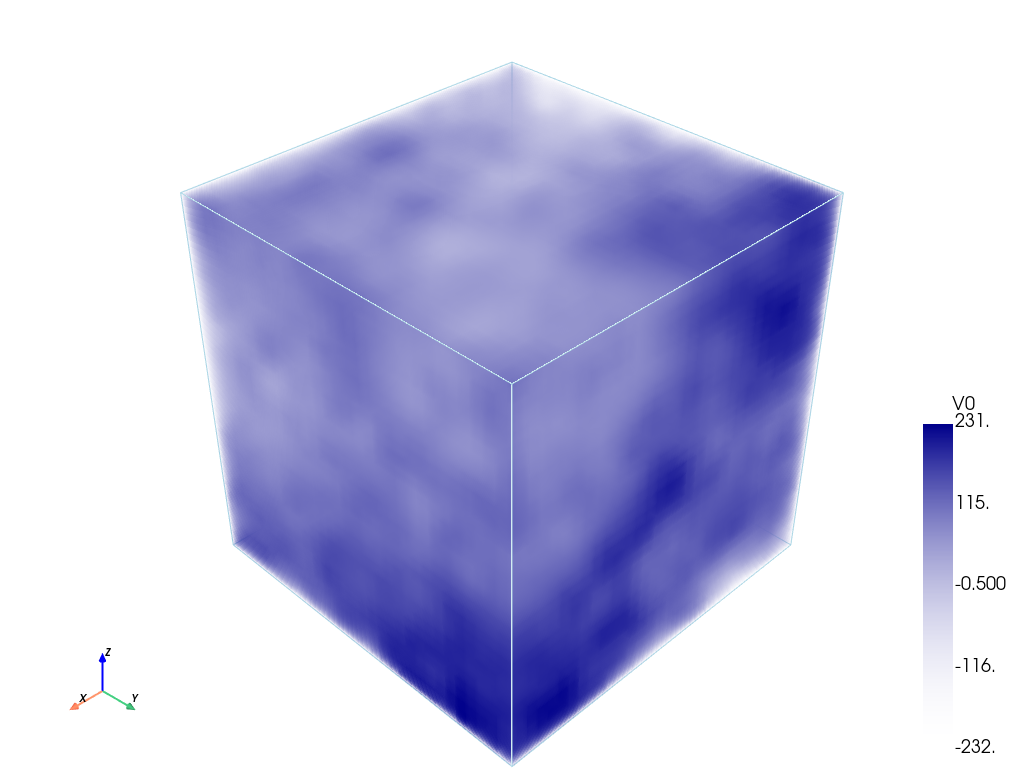

In [15]:
# Plot
cmap = gn.customcolors.custom_cmap(['white', 'darkblue'])
gn.imgplot3d.drawImage3D_volume(im, iv=0, cmap=cmap, scalar_bar_kwargs={'vertical':True})

In [16]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)
# Interactive figure 

cmap = gn.customcolors.custom_cmap(['white', 'darkblue'])
pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
gn.imgplot3d.drawImage3D_volume(im, plotter=pp, iv=0, cmap=cmap, scalar_bar_kwargs={'vertical':True})
pp.show() # open a pop-up window (interactive plot),
          # after closing the pop-up window, the position of the camera is retrieved in output.